## Filtering corrupted data
Those images that do not contain "JFIF" in their header.

In [1]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

import tensorflow as tf

tf.config.set_logical_device_configuration(
    tf.config.list_physical_devices('GPU')[0],
    [tf.config.LogicalDeviceConfiguration(memory_limit=10240)]
)

num_skipped = 0
for folder_name in os.listdir("lfw-copy"):
    folder_path = os.path.join("lfw-copy", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")


2023-12-17 14:43:51.981582: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-17 14:43:52.006284: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-17 14:43:52.006309: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-17 14:43:52.006965: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-17 14:43:52.011282: I tensorflow/core/platform/cpu_feature_guar

Deleted 0 images.


2023-12-17 14:43:53.135509: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-17 14:43:53.159879: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-17 14:43:53.160005: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Getting the datasets (training + validation)

In [7]:
image_size = (100, 100)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "lfw-copy",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 13233 files belonging to 5749 classes.
Using 10587 files for training.
Using 2646 files for validation.


## Displaying 9 images

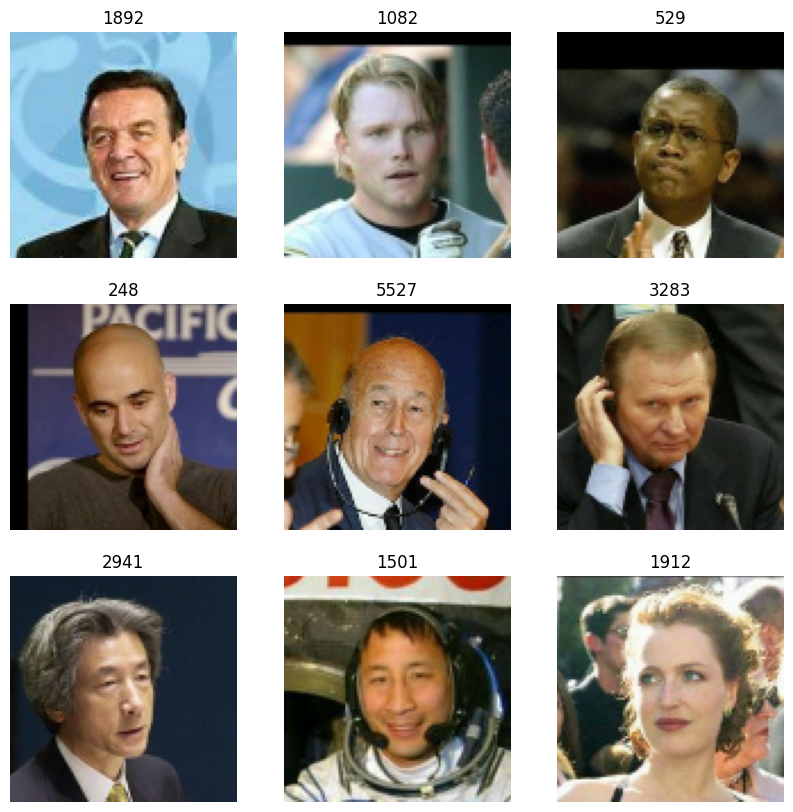

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


## Configuring for performance

In [10]:
train_ds = train_ds.map(
    lambda img, label: (img, label),
    num_parallel_calls=tf_data.AUTOTUNE,
)

train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)


## Making the model

In [11]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("sigmoid")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("sigmoid")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("sigmoid")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("sigmoid")(x)

    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(num_classes, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=1)


## Training

In [12]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)


Epoch 1/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - acc: 2.5398e-04 - loss: -11520.4854 - val_acc: 0.0000e+00 - val_loss: -43473.4805
Epoch 2/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 29s 345ms/step - acc: 2.3848e-04 - loss: -50283.7031 - val_acc: 0.0000e+00 - val_loss: -82968.6094
Epoch 3/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 28s 343ms/step - acc: 1.7773e-04 - loss: -89871.5938 - val_acc: 0.0000e+00 - val_loss: -127221.6328
Epoch 4/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 28s 343ms/step - acc: 1.7057e-04 - loss: -131991.5469 - val_acc: 0.0000e+00 - val_loss: -171407.6250
Epoch 5/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 28s 342ms/step - acc: 3.7334e-04 - loss: -176964.9844 - val_acc: 0.0000e+00 - val_loss: -218441.0781
Epoch 6/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 28s 338ms/step - acc: 9.7885e-05 - loss: -222862.1250 - val_acc: 0.0000e+00 - val_loss: -261906.7812
Epoch 7/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 28s 339ms/step - acc: 2.9583e-04 - loss: -271655.5938 - val_acc: 0.0000e+00 - val_loss: -311225.8750
Epoch 8/25
83/83 ━━━━━━━━━━━━━━━━━

## Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
There is a 100.00% chance that there is a face on this image.


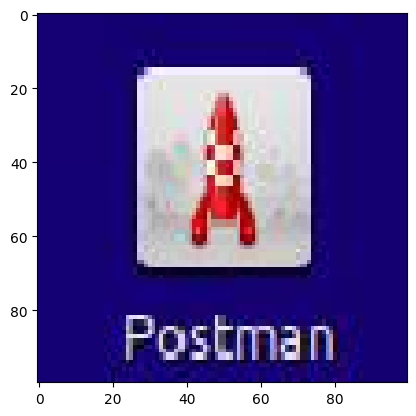

In [18]:
img = keras.utils.load_img("/home/dario/Pictures/test.jpg", target_size=image_size)
# img = keras.utils.load_img("lfw-copy/Zumrati_Juma/Zumrati_Juma_0001.jpg", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"There is a {100 * score:.2f}% chance that there is a face on this image.")
